# Лабораторная работа №4

Шубина София Антоновна НПИбд-02-23

Рассмотрим задачу разложения временного ряда на компоненты используя метод SSA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg 

In [4]:
# Загрузка данных
data = pd.read_csv('covid_usa.csv', parse_dates=['date'], index_col='date')

print("Информация о данных:")
print(data.info())

print("\nПервые 5 строк:")
print(data.head())

print("\nПропуски:")
print(data.isnull().sum())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 674 entries, 2020-05-01 to 2022-03-05
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cases   674 non-null    int64
dtypes: int64(1)
memory usage: 10.5 KB
None

Первые 5 строк:
            cases
date             
2020-05-01  33970
2020-05-02  29474
2020-05-03  26140
2020-05-04  21962
2020-05-05  23709

Пропуски:
cases    0
dtype: int64


Создаем линейный график временного ряда данных о заболеваемости COVID-19. На оси X отображаются даты, на оси Y - количество выявленных случаев заболевания. График размером 16×14 дюймов содержит заголовок "Статистика о заболеваниях", подписи осей "Дата" и "Число заболевших", а также вспомогательную сетку и легенду. Визуализация позволяет наблюдать общую динамику пандемии, выделять периоды роста и спада заболеваемости, анализировать волновой характер распространения вируса.

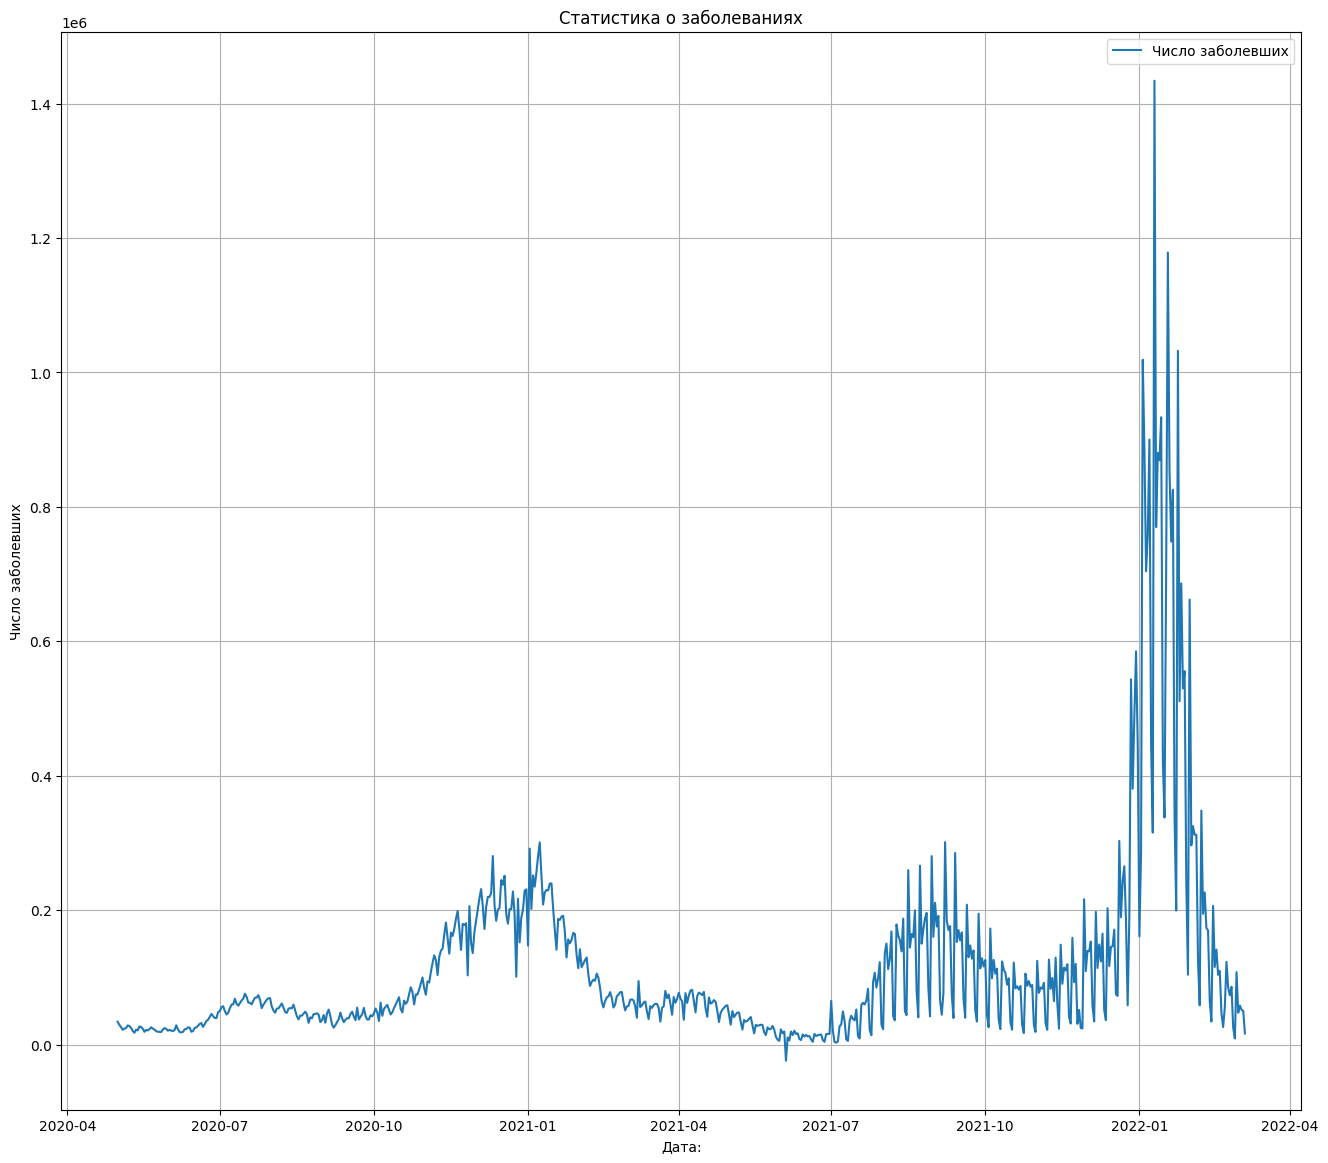

In [5]:
plt.figure(figsize=(16,14))
plt.plot(data,label="Число заболевших")
plt.title("Статистика о заболеваниях")
plt.xlabel("Дата:")
plt.ylabel("Число заболевших")
plt.grid("True")
plt.legend()
plt.show()

Реализуем метод SSA (анализ сингулярного спектра) для декомпозиции временного ряда. Сначала создается матрица Ганкеля из исходных данных, где каждый столбец представляет сдвинутую последовательность значений. Затем вычисляется ковариационная матрица путем перемножения транспонированной и исходной матриц. Для этой матрицы находятся собственные значения и векторы, которые определяют основные компоненты ряда. Результатом работы являются собственные значения, показывающие вклад каждой компоненты в общую дисперсию, собственные векторы и матрица главных компонент, содержащая разложенные составляющие временного ряда.

In [6]:
# разложение на главные компоненты
# arr - исходный временной ряд
# l - длина обучающей строки (количество уравнений)
# k - длина окна (количество неизвестных)

def ssa_decomposition( arr, l, k):
        
    matrix_h = np.empty( [ l, k ] ) #матрица Ганкеля    
    for i in range( l ):
        for j in range( k ):
            matrix_h[ i, j ] = arr[ i + j ]
            
    mult_matrix_h = np.matmul( matrix_h.T, matrix_h ) 
    eig_value, eig_vector  = linalg.eigh( mult_matrix_h ) 
    matrix_v = np.matmul( matrix_h, eig_vector ) 
              
    return  eig_value, eig_vector, matrix_v

Выполняем диагональное усреднение матрицы для восстановления временного ряда. Функция преобразует двумерную матрицу обратно в одномерный ряд, усредняя значения вдоль диагоналей. Процесс разделен на три этапа: для начальных диагоналей используется нарастающее усреднение, для центральных - постоянное усреднение по всей длине диагонали, а для конечных - убывающее усреднение. В результате возвращается сглаженный временной ряд, восстановленный из матричных компонент.

In [15]:
# диагональное усреднение, функция возвращает сглаженный ряд

def diagonal_average( arr ):
    
    l = arr.shape[ 0 ] # количество строк в матрице
    k = arr.shape[ 1 ] # количество столбцов в матрице
    l_ = np.amin( arr.shape ) # минимальное значение между l и k
    k_ = np.amax( arr.shape ) # максимально значение между l и k
    n = np.sum( arr.shape ) - 1 # длина сглаженного ряда
    
    if l < k:
        arr_ = arr
    else:
        arr_ = arr.T
        
    g = np.zeros( [ n ] ) 
    for j in range( n ):
        
        if j < ( l_ - 1 ):
            for m in range( j + 1 ):
                g[ j ] += ( 1/( j + 1 ) )*arr_[ m, j - m ]
        
        elif ( l_ - 1 ) <= j < k_:
            for m in range( l_ ):
                g[ j ] += ( 1/l_ )*arr_[ m, j - m ]
        
        elif  k_ <= j < n:
            for m in range( ( j - k_ + 1 ) , ( n - k_ + 1 ) ):
                g[ j ] += ( 1/( n - j ) )*arr_[ m, j - m ]
          
    return g         

выполняем полное SSA-разложение временного ряда. Функция автоматически вычисляет параметры: длина окна составляет 80% от ряда, количество компонент определяется по формуле. После SSA-разложения каждая компонента восстанавливается через внешнее произведение главных компонент и собственных векторов с последующим диагональным усреднением. Результатом является матрица, где каждая строка представляет отдельную компоненту исходного временного ряда, отсортированную по убыванию значимости.

In [14]:
# функция возвращает массив главных компонент

def main_components( arr ):
    
    l = int( len( arr )*0.8 )
    k = len( arr ) - l + 1
    component = np.zeros( [ k, k + l - 1 ] ) 
    eig_value, eig_vector, matrix_v = ssa_decomposition( arr, l, k )
    
    for i in range( k ):
        x = np.zeros( [ l, k ] )
        x = np.outer( matrix_v[:, i], eig_vector[:, i].T)
        component[ i ] = diagonal_average( x )

    return component

Загружаем данные о случаях COVID-19 из CSV-файла, устанавливая дату в качестве индекса. Строится график динамики заболеваемости с сеткой. Затем выполняется SSA-анализ: временной ряд разлагается на главные компоненты с помощью функции main_components, которая выделяет основные составляющие ряда - тренд, периодические колебания и шум.

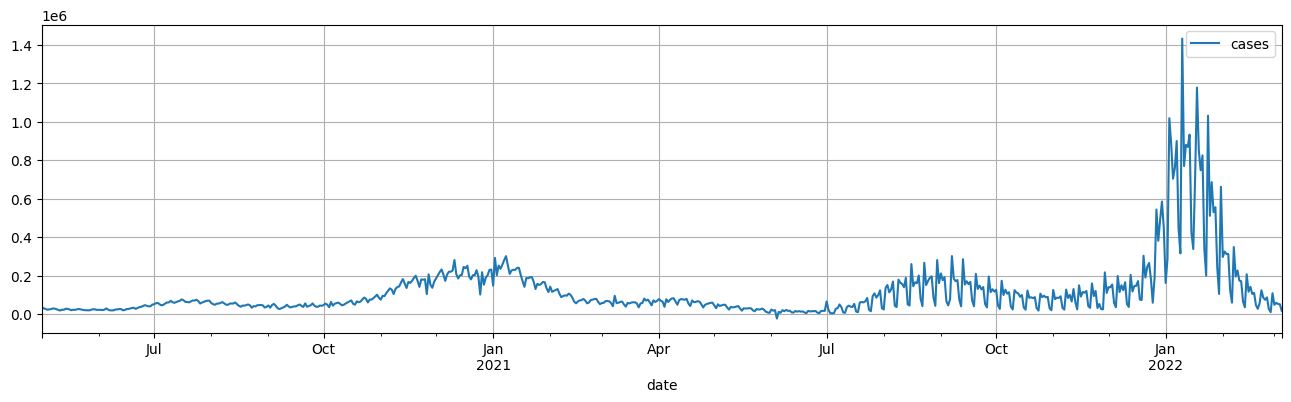

In [13]:
data = pd.read_csv('covid_usa.csv', index_col=[0], parse_dates=[0])
data.plot(figsize=(16, 4), grid=True)
plt.show()

# Вызов SSA анализа
components = main_components(data['cases'].values)

Подготавливаем данные для SSA-анализа. Временной ряд преобразуется в массив NumPy. Длина окна L устанавливается в 95% от длины ряда, что позволяет выделить долгосрочные тренды. Параметр K вычисляется как количество возможных окон. Функция ssa_decomposition выполняет разложение ряда на собственные значения, собственные векторы и главные компоненты, которые представляют основные паттерны данных.

In [10]:
arr_data = data.iloc[:, 0].to_numpy()
l = int(len(arr_data)*0.95)
k = len(arr_data) - l + 1

eig_value, eig_vector, matrix_v = ssa_decomposition(arr_data, l, k)

Выводим **10 наименьших собственных значений** из результатов SSA-разложения. Эти значения соответствуют наименее значимым компонентам временного ряда, которые обычно представляют собой **шум** или очень слабые периодические составляющие. Малые собственные значения указывают на компоненты с минимальным вкладом в общую дисперсию данных.

In [11]:
eig_value[-10:]

array([3.20800786e+12, 6.13257744e+12, 6.18023216e+12, 1.33826991e+13,
       1.67783707e+13, 1.68942353e+13, 1.73610620e+13, 1.74399375e+13,
       8.65699007e+13, 6.67156042e+14])

Выполняем SSA-разложение временного ряда на главные компоненты и визуализируем первые 10 компонент. Для каждой компоненты создается отдельный график, отображающий ее вклад в исходные данные. Первые компоненты обычно соответствуют тренду и основным периодическим составляющим, а последующие - менее значимым колебаниям и шуму. 

Компонента 1


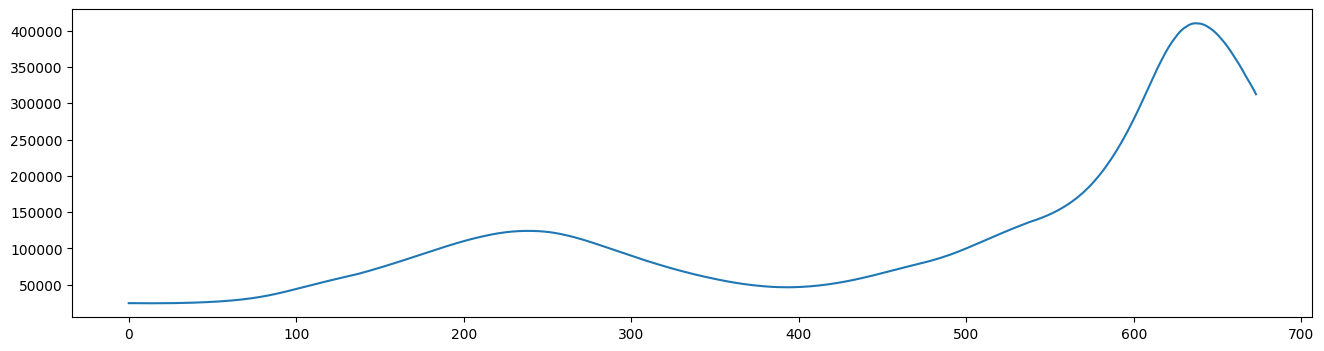

Компонента 2


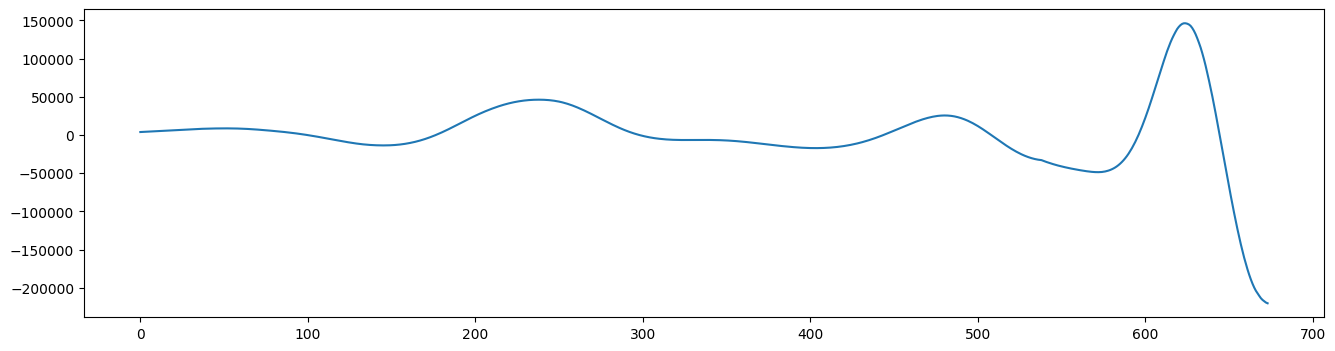

Компонента 3


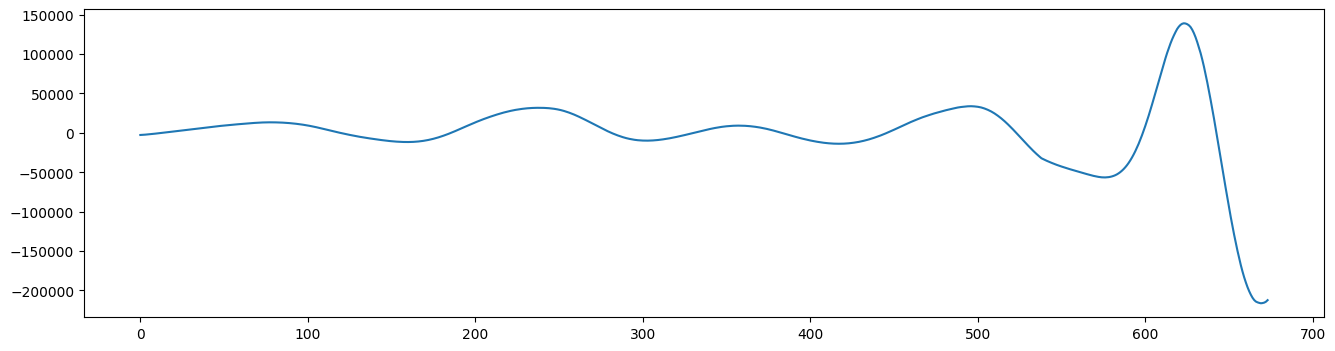

Компонента 4


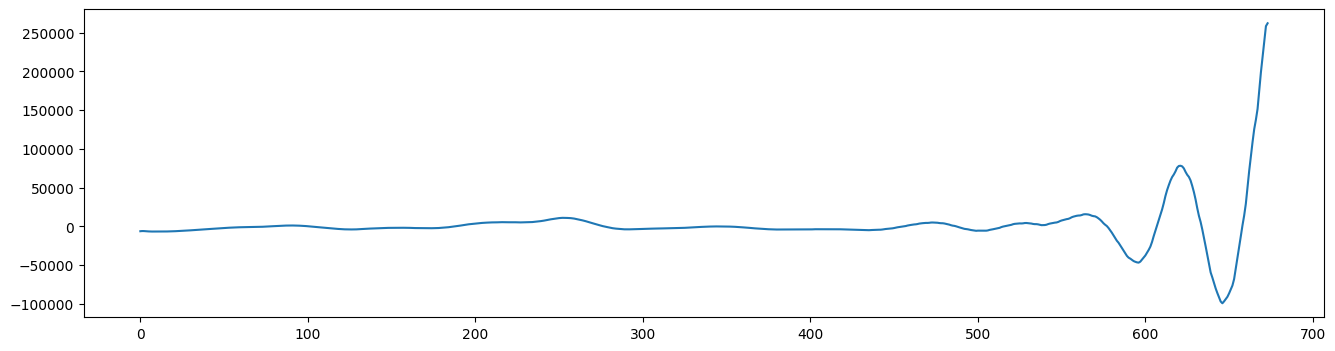

Компонента 5


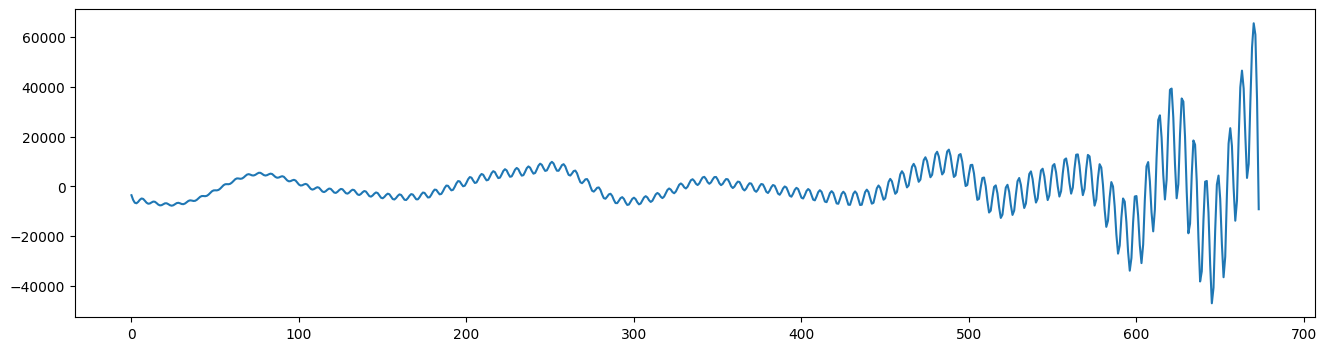

Компонента 6


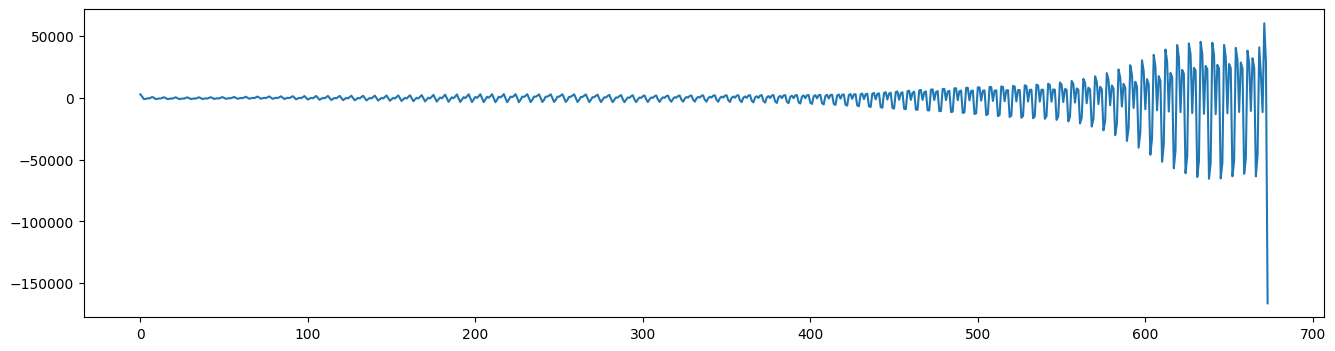

Компонента 7


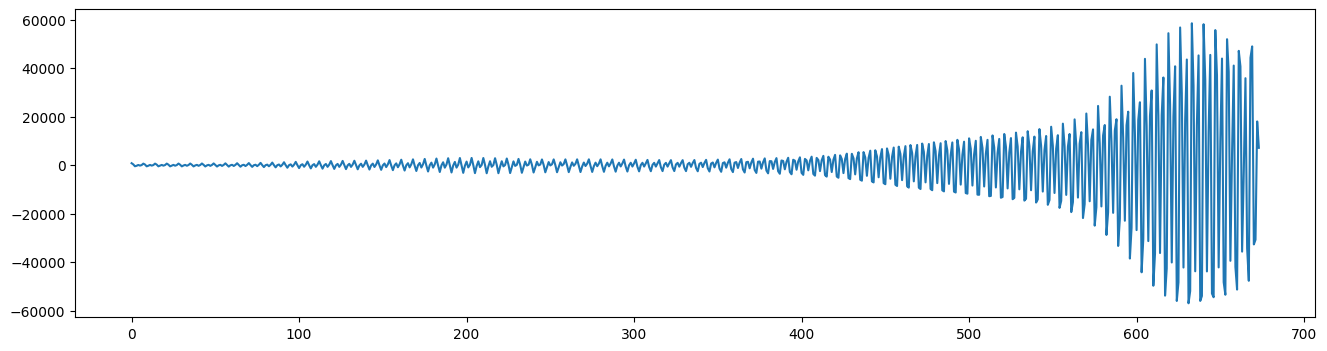

Компонента 8


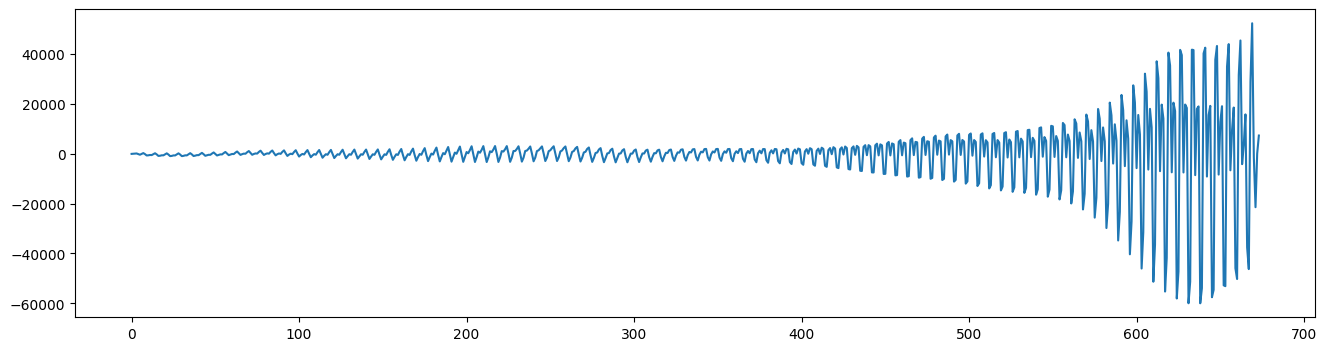

Компонента 9


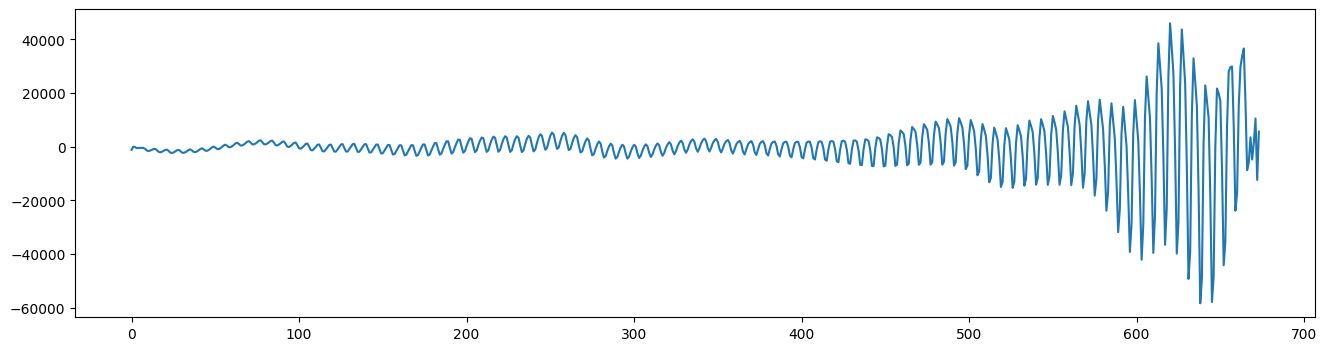

Компонента 10


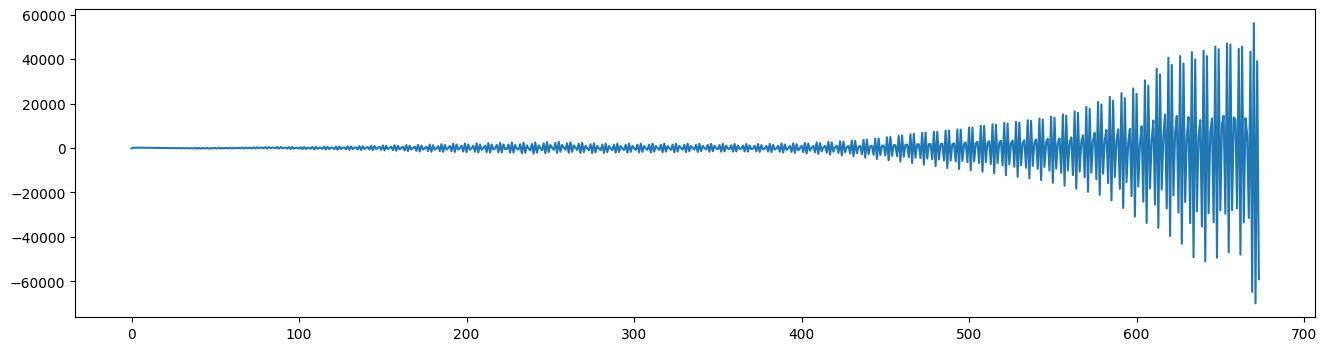

In [ ]:
# Выводим последние 10 компонент
for i in range(1, 11):
    print(f'Компонента {i}')
    plt.figure(figsize=(16, 4))
    plt.plot(components[-i])  
    plt.show()

Строим отдельные графики для трендовой и периодической составляющих временного ряда. На одном изображении отображаются две линии: тренд (сумма первых четырех компонент SSA) и периодическая компонента (пятая компонента SSA). Это позволяет визуально сравнить характер и амплитуду трендовых изменений и сезонных колебаний, оценить их относительный вклад в динамику ряда без наложения на исходные данные.

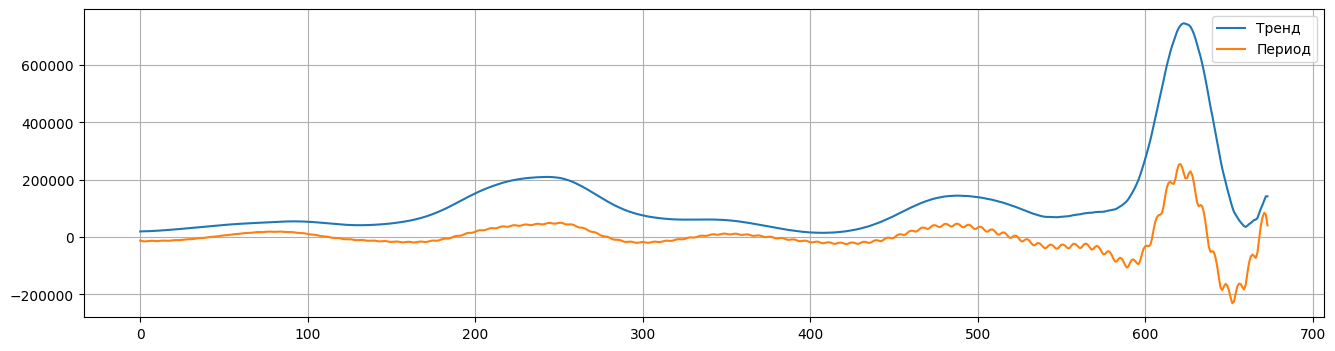

In [31]:
# тренд и периодическая компонента ряда
plt.figure(figsize=(16, 4))
plt.plot(sum(components[-4:]))
plt.plot(sum(components[-5:-2]))
plt.grid()
plt.legend(['Тренд', 'Период'])
plt.show()

 Создаем копию исходных данных и добавляем в нее два новых столбца: тренд (сумма первых четырех компонент SSA) и периодическую составляющую (пятая компонента SSA). Затем строится график, на котором одновременно отображаются исходный временной ряд, выделенный тренд и периодическая компонента. Это позволяет визуально оценить вклад трендовой и сезонной составляющих в общее поведение исходных данных.

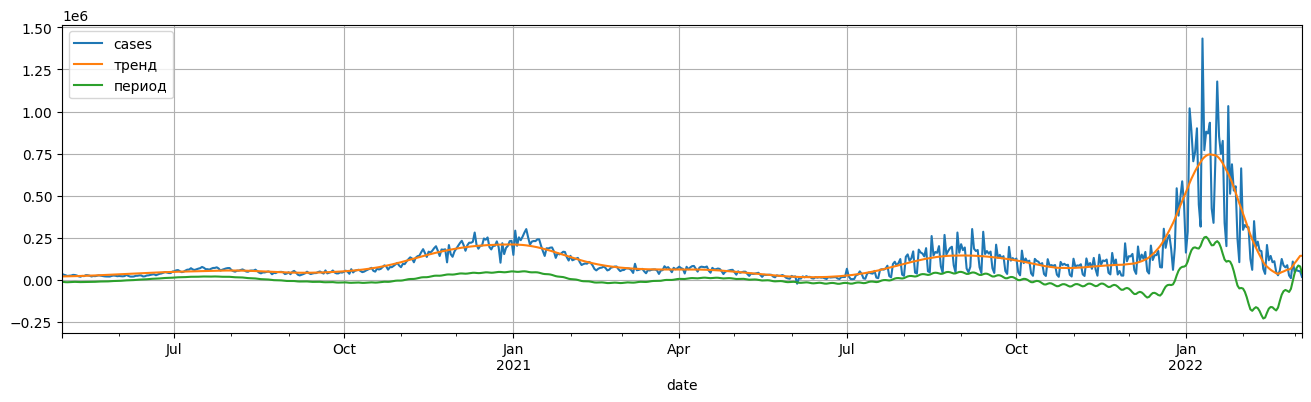

In [30]:
data_copy = data.copy()
data_copy['тренд'] = sum(components[-4:])
data_copy['период'] = sum(components[-5:-2])

data_copy.plot(figsize=(16, 4), grid=True)
plt.show()

Метод SSA позволяет декомпозировать временной ряд на составляющие через анализ сингулярных компонент, где тренд идентифицируется как компоненты с наибольшими сингулярными значениями, представляющие плавные низкочастотные колебания и общую направленность ряда.

 Периодическая составляющая определяется как парные компоненты с близкими сингулярными значениями, которые образуют гармоники и отражают сезонные колебания с определенной периодичностью и стабильной амплитудой. 
 
 Шумовая составляющая состоит из компонент с малыми сингулярными значениями, характеризующихся быстрыми нерегулярными колебаниями, низкой автокорреляцией и отсутствием четкой структуры. 

 ![компоненты временных рядов](определение.jpg)

## Вывод

На основе проведенной лабораторной работы по разложению временного ряда данных о заболеваемости COVID-19 методом SSA можно сделать следующие выводы.

Метод анализа сингулярного спектра успешно продемонстрировал свою эффективность для декомпозиции сложного эпидемиологического временного ряда на основные составляющие. Визуальный анализ графиков подтверждает, что исходные данные были качественно разделены на три ключевые компоненты: трендовую, периодическую и шумовую составляющие.

Трендовая составляющая, полученная как сумма первых четырех компонент SSA, наглядно отображает общую динамику развития пандемии. На графике тренда четко прослеживаются характерные периоды роста и спада заболеваемости, соответствующиые реальным волнам пандемии COVID-19. Плавный характер изменений тренда без резких колебаний подтверждает его низкочастотную природу и способность отражать долгосрочные тенденции в распространении заболевания.

Периодическая компонента, представленная пятой компонентой SSA, выявляет регулярные сезонные колебания заболеваемости. Анализ графика показывает стабильную повторяемость колебаний с определенной амплитудой и периодом, что может быть связано с сезонными факторами распространения вируса и изменением поведения людей в разные периоды года. Хотя амплитуда периодической составляющей существенно меньше амплитуды тренда, ее вклад в общую динамику ряда остается статистически значимым.

Шумовая составляющая, состоящая из компонент с малыми собственными значениями, характеризуется нерегулярными быстрыми колебаниями без четкой структуры. Исключение этих компонент из анализа позволяет очистить данные от случайных колебаний и сосредоточиться на существенных закономерностях, что значительно улучшает качество последующего анализа и прогнозирования.

С практической точки зрения, полученные результаты имеют важное прикладное значение. Выделение тренда позволяет эпидемиологам и органам здравоохранения оценивать общую направленность развития пандемии и своевременно идентифицировать новые волны заболеваемости. Периодическая компонента может быть использована для прогнозирования сезонных всплесков заболеваемости и планирования профилактических мероприятий. В целом, разложение сложного временного ряда на составляющие компоненты значительно упрощает анализ эпидемиологических данных и помогает выявлять скрытые закономерности, что способствует принятию более обоснованных управленческих решений в области здравоохранения.